<a href="https://colab.research.google.com/github/fiobouvierlei/FER/blob/main/FER_CNN_Adam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Importing necessary libraries**

In [1]:
!pip install scikit-plot

In [2]:
import pandas as pd
import numpy as np
import scikitplot
import random
import seaborn as sns
import keras
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import warnings
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.python.keras.utils.np_utils import to_categorical
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D,Activation,Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.simplefilter("ignore")
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.regularizers import l1, l2
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# **2. Importing dataset**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv("/content/drive/MyDrive/Project/FER_CNN/fer2013.csv")
data.shape

(35887, 3)

*To see the dataset has any missing values.*

---



In [5]:
data.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

In [6]:
data.head()


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


# **3. Data pre-processing**

In [7]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
fig = px.bar(x = CLASS_LABELS,
             y = [list(data['emotion']).count(i) for i in np.unique(data['emotion'])] ,
             color = np.unique(data['emotion']) ,
             color_continuous_scale="Emrld")
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

## **(DONT RUN)3.1 Shuffling the data**

*Firstly, we will shuffle the data using sample() function and determining fraction as 1 to shuffle the data by changing the rows.*

---



In [ ]:
data = data.sample(frac=1)

## **3.2 One Hot Encoding**

*Then, we will do one hot encoding operation to change the categorical labels as numeric labels to learning algorithm can work better in predictions process.*

---



In [8]:
labels = to_categorical(data[['emotion']], num_classes=7)

*Changing image pixels to Numpy array*

---



In [9]:
train_pixels = data["pixels"].astype(str).str.split(" ").tolist()
train_pixels = np.uint8(train_pixels)

## **3.3 Standardization**

*We will change the data structure to feed the standart scaler to implement standardization process to our data. Since StandartScaler() function only takes 2 dimensional array we will reshape the data then apply our scaler to make the mean zero and standart deviation as unit.*

---



In [10]:
pixels = train_pixels.reshape((35887*2304,1))

In [11]:
scaler = StandardScaler()
pixels = scaler.fit_transform(pixels)

## **3.4 Reshaping the data (48,48)**

*After that, we will reshape the data to make our image pixels ready to split operation.*

---



In [12]:
pixels = train_pixels.reshape((35887, 48, 48,1))

## **3.5 Train test validation split**

*Now, we have 35887 images with each containing 48x48 pixels. We will split the data into train,test and Validation data to feed and evaluate and validate our data with the ratio of 10%.*

---



In [ ]:
'X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.1, shuffle=False)
'X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

### **3.5.1 category**

In [13]:
def split_data(idxs):
    n_data = len(idxs)
    val_start = round(n_data / 10 * 8)
    test_start = round(n_data / 10 * 9)
    train_idxs = idxs[:val_start]
    val_idxs = idxs[val_start: test_start]
    test_idxs = idxs[test_start:]
    return train_idxs, val_idxs, test_idxs

In [14]:
cat_id2pic_idxs_map = data.groupby(['emotion']).groups

In [15]:
train_idxs, val_idxs, test_idxs = [], [], []
for cat_id, pic_idxs in cat_id2pic_idxs_map.items():
    sub_train_idxs, sub_val_idxs, sub_test_idxs = split_data(pic_idxs.tolist())
    train_idxs += sub_train_idxs
    val_idxs += sub_val_idxs
    test_idxs += sub_test_idxs
len(train_idxs), len(val_idxs), len(test_idxs)

(28710, 3588, 3589)

In [16]:
import itertools

def merge_lists(lists):
    return list(itertools.chain(*lists))


def get_cat_count(cat_id2pic_idxs_map):
    return {i: len(j) for i, j in cat_id2pic_idxs_map.items()}


def resampling(cat_id2pic_idxs_map):
    counter = get_cat_count(cat_id2pic_idxs_map)
    max_count = max(counter.values())

    def balanced_fill(idxs, max_len):
        idxs = idxs.tolist()
        curr_len = len(idxs)
        quotient = max_len // curr_len
        remainder = max_len % curr_len
        return idxs * quotient + idxs[:remainder]

    return {cat_id: balanced_fill(pic_idxs, max_count) for cat_id, pic_idxs in cat_id2pic_idxs_map.items()}



In [17]:
train_cat_id2pic_idxs_map = data.iloc[train_idxs].groupby('emotion').groups
new_train_cat_id2pic_idxs_map = resampling(train_cat_id2pic_idxs_map)
train_idxs = merge_lists(new_train_cat_id2pic_idxs_map.values())

print(get_cat_count(train_cat_id2pic_idxs_map))
print(get_cat_count(new_train_cat_id2pic_idxs_map))
print(train_idxs)

{0: 3962, 1: 438, 2: 4097, 3: 7191, 4: 4862, 5: 3202, 6: 4958}
{0: 7191, 1: 7191, 2: 7191, 3: 7191, 4: 7191, 5: 7191, 6: 7191}
[0, 1, 10, 22, 23, 27, 38, 40, 43, 56, 65, 68, 74, 76, 77, 90, 91, 93, 107, 117, 120, 122, 123, 126, 134, 149, 150, 157, 169, 184, 186, 188, 197, 202, 203, 221, 225, 229, 233, 235, 241, 242, 245, 248, 249, 251, 259, 263, 278, 280, 294, 295, 298, 307, 323, 338, 342, 353, 355, 360, 368, 369, 374, 377, 387, 393, 404, 409, 412, 421, 429, 431, 433, 434, 464, 469, 470, 481, 489, 496, 499, 509, 515, 516, 519, 521, 525, 526, 545, 558, 563, 564, 581, 589, 608, 612, 617, 624, 625, 633, 636, 654, 665, 671, 676, 677, 700, 704, 714, 716, 727, 740, 743, 756, 764, 765, 778, 790, 797, 816, 823, 824, 834, 835, 842, 850, 851, 854, 860, 861, 876, 879, 881, 883, 900, 908, 923, 928, 932, 935, 938, 946, 950, 961, 962, 963, 965, 966, 971, 974, 980, 985, 998, 1015, 1016, 1018, 1024, 1039, 1051, 1061, 1066, 1071, 1090, 1098, 1102, 1105, 1106, 1108, 1122, 1123, 1124, 1127, 1147, 1150, 1

In [18]:
X_train = pixels[train_idxs]
X_val = pixels[val_idxs]
X_test = pixels[test_idxs]

In [19]:
y_train = labels[train_idxs]
y_val = labels[val_idxs]
y_test = labels[test_idxs]

In [20]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(50337, 48, 48, 1)
(3589, 48, 48, 1)
(3588, 48, 48, 1)


In [21]:
y_train.shape

(50337, 7)

*We can see some train data containing one sample of each class with the help of this plot code.*

---



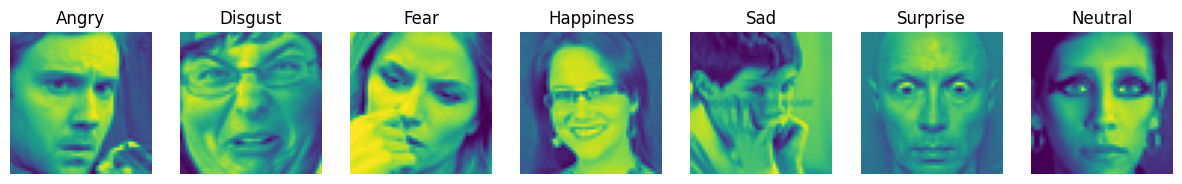

In [22]:
plt.figure(figsize=(15,23))
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}
train_cat_count = get_cat_count(new_train_cat_id2pic_idxs_map)
train_cat_count = [train_cat_count[i] for i in range(7)]
i = 0
for cat_id in range (7):
    train_idx = sum(train_cat_count[:cat_id])
    img = np.squeeze(X_train[train_idx])
    plt.subplot(1,7,i+1)
    plt.imshow(img)
    # index = p.argmax(y_train[pic_idx])
    plt.title(label_dict[cat_id])
    plt.axis('off')
    i += 1
plt.show()

## **3.6 Data augmentation using ImageDataGenerator**

*We can do data augmentation to have more data to train and validate our model to prevent overfitting. Data augmentation can be done on training and validation sets as it helps the model become more generalize and robust.*

---



In [23]:
datagen = ImageDataGenerator(  width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2)
valgen = ImageDataGenerator(   width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2)

In [24]:
datagen.fit(X_train)
valgen.fit(X_val)

In [25]:
train_generator = datagen.flow(X_train, y_train, batch_size=64)
val_generator = datagen.flow(X_val, y_val, batch_size=64)

*Our dataset is ready to feed our model. We will look at our model architecture.*

---



# **4. Design a model**

## **4.1 CNN model**

*CNN model has many layers with different units such as Convolutional layer, Max pooling layer, Batch normalization and Drop out layer to regularize the model.*

---



In [32]:
def cnn_model():

  model= tf.keras.models.Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
  model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(256,activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Dense(512,activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Dense(7, activation='softmax'))
  model.compile(
    optimizer = Adam(lr=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
  return model

In [33]:
model = cnn_model()

*Then, we compile our model with Adam optimizer with 0.0001 learning rate and chose metric as accuracy, then loss as categorical crossentropy*

---



In [34]:
model.compile(
    optimizer = Adam(lr=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_7 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 128)      

## **4.2 Early stopping**

*Adding checkpointer to implement Early Stopping to prevent overfitting.*

---



In [36]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1,
                              restore_best_weights=True,mode="max",patience = 10),
                ModelCheckpoint('/content/drive/MyDrive/Project/FER_CNN/best_model.h5',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")]

In [37]:
history = model.fit(train_generator,
                    epochs=50,
                    batch_size=64,
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)


Epoch 1/50
787/787 [==============================] - ETA: 0s - loss: 5.3567 - accuracy: 0.2185
Epoch 1: val_accuracy improved from -inf to 0.26421, saving model to /content/drive/MyDrive/Project/FER_CNN/best_model.h5
787/787 [==============================] - 44s 51ms/step - loss: 5.3567 - accuracy: 0.2185 - val_loss: 2.8441 - val_accuracy: 0.2642
Epoch 2/50
787/787 [==============================] - ETA: 0s - loss: 2.8764 - accuracy: 0.3706
Epoch 2: val_accuracy did not improve from 0.26421
787/787 [==============================] - 40s 51ms/step - loss: 2.8764 - accuracy: 0.3706 - val_loss: 3.0565 - val_accuracy: 0.2639
Epoch 3/50
786/787 [============================>.] - ETA: 0s - loss: 2.7246 - accuracy: 0.4386
Epoch 3: val_accuracy improved from 0.26421 to 0.40608, saving model to /content/drive/MyDrive/Project/FER_CNN/best_model.h5
787/787 [==============================] - 40s 50ms/step - loss: 2.7250 - accuracy: 0.4386 - val_loss: 2.8658 - val_accuracy: 0.4061
Epoch 4/50
786/

## **4.3 Visualizing results**

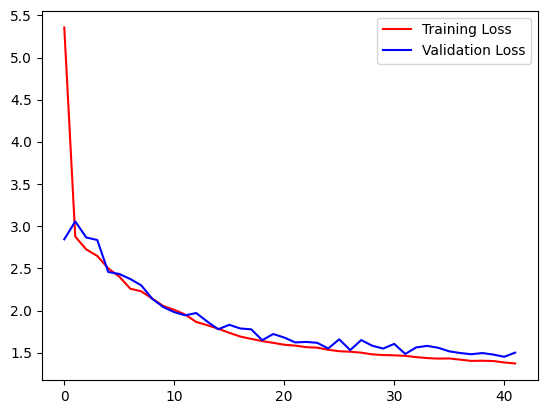

In [38]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()


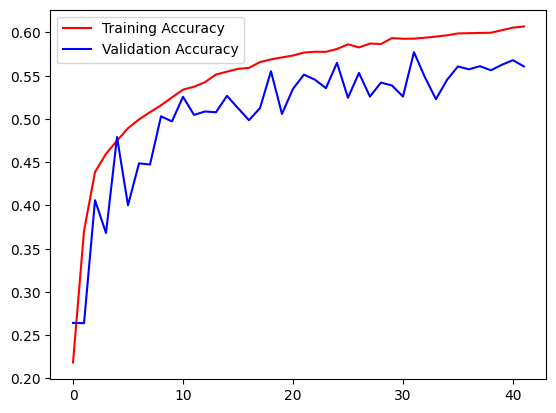

In [39]:
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

In [40]:
loss = model.evaluate(X_test,y_test)
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 2s 10ms/step - loss: 1.4194 - accuracy: 0.6004
Test Acc: 0.6004458069801331


In [41]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

113/113 [==============================] - 1s 6ms/step


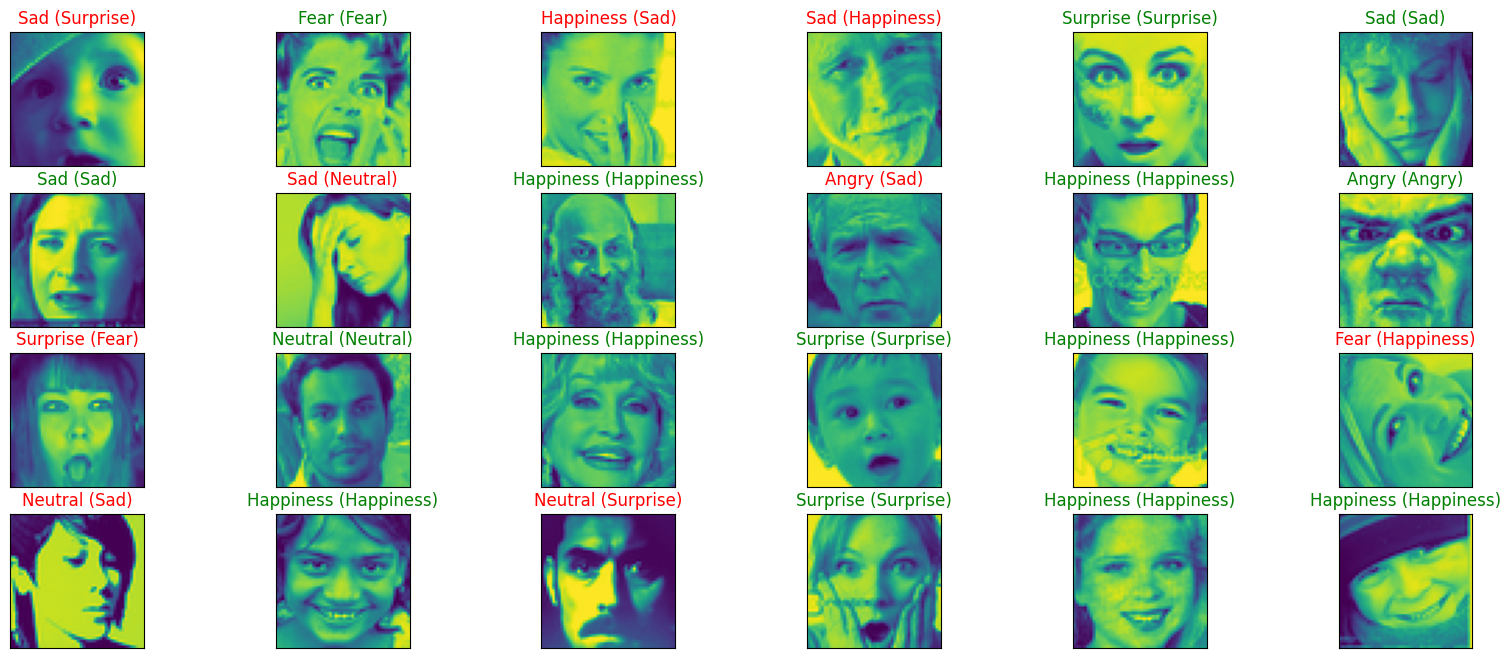

In [42]:
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]

    ax.set_title("{} ({})".format((predict_index),
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

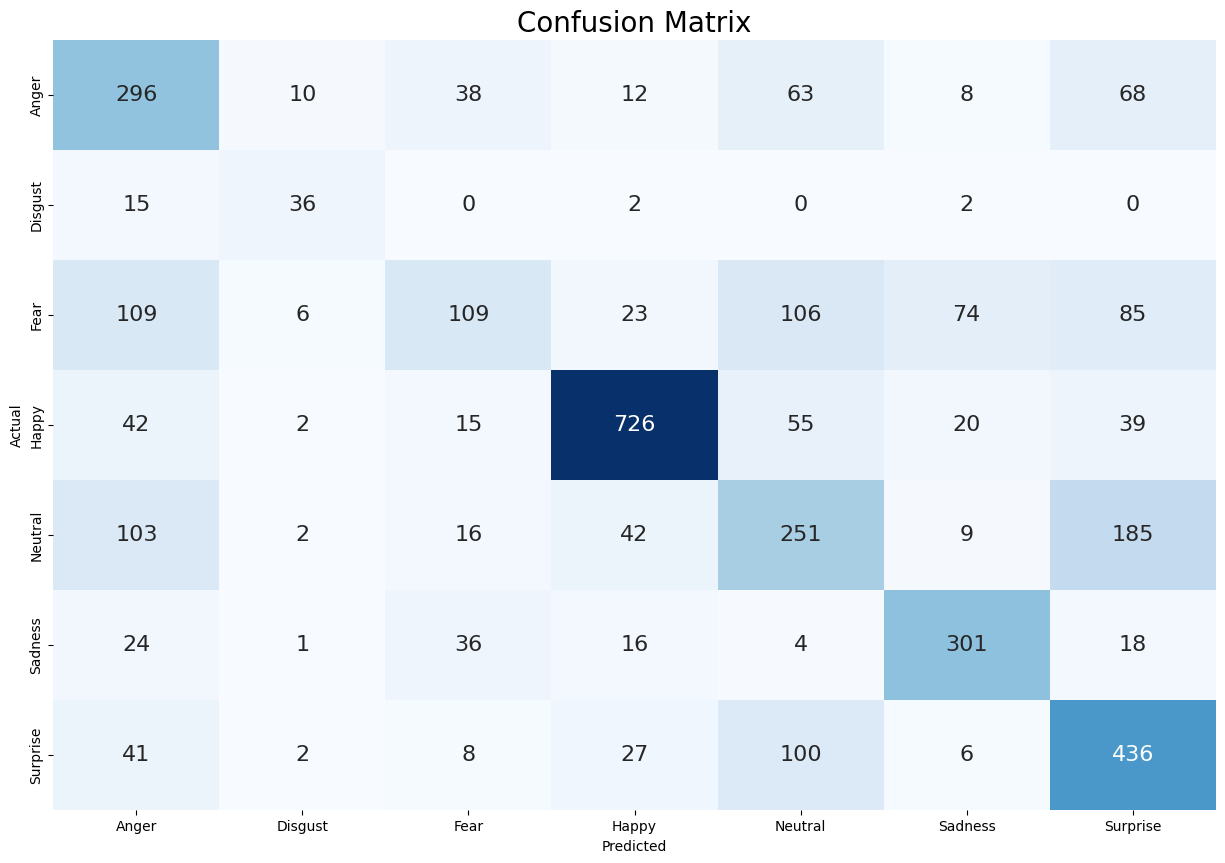

In [43]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (15,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [44]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.470     0.598     0.526       495
           1      0.610     0.655     0.632        55
           2      0.491     0.213     0.297       512
           3      0.856     0.808     0.831       899
           4      0.434     0.413     0.423       608
           5      0.717     0.752     0.734       400
           6      0.525     0.703     0.601       620

    accuracy                          0.600      3589
   macro avg      0.586     0.592     0.578      3589
weighted avg      0.603     0.600     0.590      3589



# **5. Fine tuning**

## **5.1 Changing optimizer**

*Changing Optimizer to Stochastic Gradient Descent (SGD)*

---



In [ ]:
model = cnn_model()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(0.001),
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

In [ ]:
history = model.fit(train_generator,
                    epochs=30,
                    batch_size=64,
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/30
455/455 [==============================] - ETA: 0s - loss: 14.8121 - accuracy: 0.1691
Epoch 1: val_accuracy did not improve from 0.54582
455/455 [==============================] - 48s 91ms/step - loss: 14.8121 - accuracy: 0.1691 - val_loss: 13.9846 - val_accuracy: 0.2384
Epoch 2/30
455/455 [==============================] - ETA: 0s - loss: 14.4001 - accuracy: 0.1794
Epoch 2: val_accuracy did not improve from 0.54582
455/455 [==============================] - 23s 51ms/step - loss: 14.4001 - accuracy: 0.1794 - val_loss: 13.8628 - val_accuracy: 0.2022
Epoch 3/30
454/455 [============================>.] - ETA: 0s - loss: 14.0690 - accuracy: 0.1891
Epoch 3: val_accuracy did not improve from 0.54582
455/455 [==============================] - 24s 53ms/step - loss: 14.0689 - accuracy: 0.1892 - val_loss: 13.5754 - val_accuracy: 0.2502
Epoch 4/30
455/455 [==============================] - ETA: 0s - loss: 13.7744 - accuracy: 0.1935
Epoch 4: val_accuracy did not improve from 0.54582
455

In [ ]:
loss = model.evaluate(X_test,y_test)
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 2s 10ms/step - loss: 8.8501 - accuracy: 0.3366
Test Acc: 0.3365840017795563


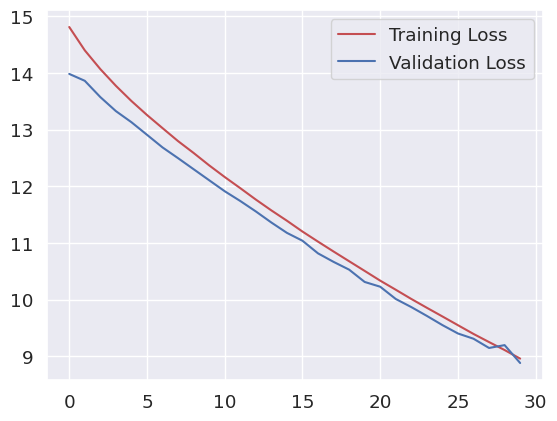

In [ ]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

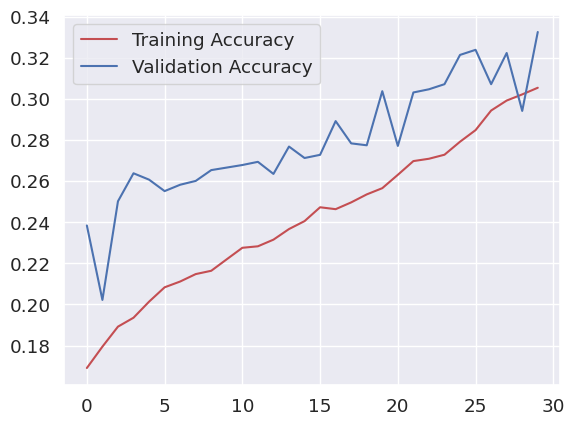

In [ ]:
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

*The model trained with SGD did not give better results than Adam optimizer.*

---



## **5.2 Changing epoch number**

*Let's change the epoch number as 50 for the cnn_model.*

---



In [ ]:
model = cnn_model()

In [ ]:
model.compile(
    optimizer = Adam(lr=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1,
                              restore_best_weights=True,mode="max",patience = 10),
                              ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                              save_best_only=True,mode="max")]

In [ ]:
history = model.fit(train_generator,
                    epochs=50,
                    batch_size=64,
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

In [ ]:
loss = model.evaluate(X_test,y_test)
print("Test Acc: " + str(loss[1]))

In [ ]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

In [ ]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [ ]:
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

*The model trained with 50 epochs has better results than the model trained with 30 epochs.*

---



## **5.3 Best parameters (Lokesh's thesis)**

In [ ]:
model = cnn_model()

In [ ]:
model.compile(
    optimizer = keras.optimizers.Nadam(lr=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1,
                              restore_best_weights=True,mode="max",patience = 20),
                              ModelCheckpoint('/content/drive/MyDrive/Project/FER_CNN/best_model_Nadam.h5',monitor="val_accuracy",verbose=1,
                              save_best_only=True,mode="max")]

In [ ]:
history = model.fit(train_generator,
                    epochs=50,
                    batch_size=64,
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/100
455/455 [==============================] - ETA: 0s - loss: 7.0176 - accuracy: 0.2220
Epoch 1: val_accuracy improved from -inf to 0.25108, saving model to best_model.h5
455/455 [==============================] - 35s 55ms/step - loss: 7.0176 - accuracy: 0.2220 - val_loss: 3.2427 - val_accuracy: 0.2511
Epoch 2/100
455/455 [==============================] - ETA: 0s - loss: 2.5638 - accuracy: 0.3303
Epoch 2: val_accuracy improved from 0.25108 to 0.34644, saving model to best_model.h5
455/455 [==============================] - 25s 54ms/step - loss: 2.5638 - accuracy: 0.3303 - val_loss: 2.5452 - val_accuracy: 0.3464
Epoch 3/100
455/455 [==============================] - ETA: 0s - loss: 2.5550 - accuracy: 0.4168
Epoch 3: val_accuracy improved from 0.34644 to 0.44644, saving model to best_model.h5
455/455 [==============================] - 25s 55ms/step - loss: 2.5550 - accuracy: 0.4168 - val_loss: 2.5291 - val_accuracy: 0.4464
Epoch 4/100
455/455 [==============================] - 

In [ ]:
loss = model.evaluate(X_test,y_test)
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 2s 10ms/step - loss: 1.2460 - accuracy: 0.6311
Test Acc: 0.6310949921607971


In [ ]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

113/113 [==============================] - 1s 8ms/step


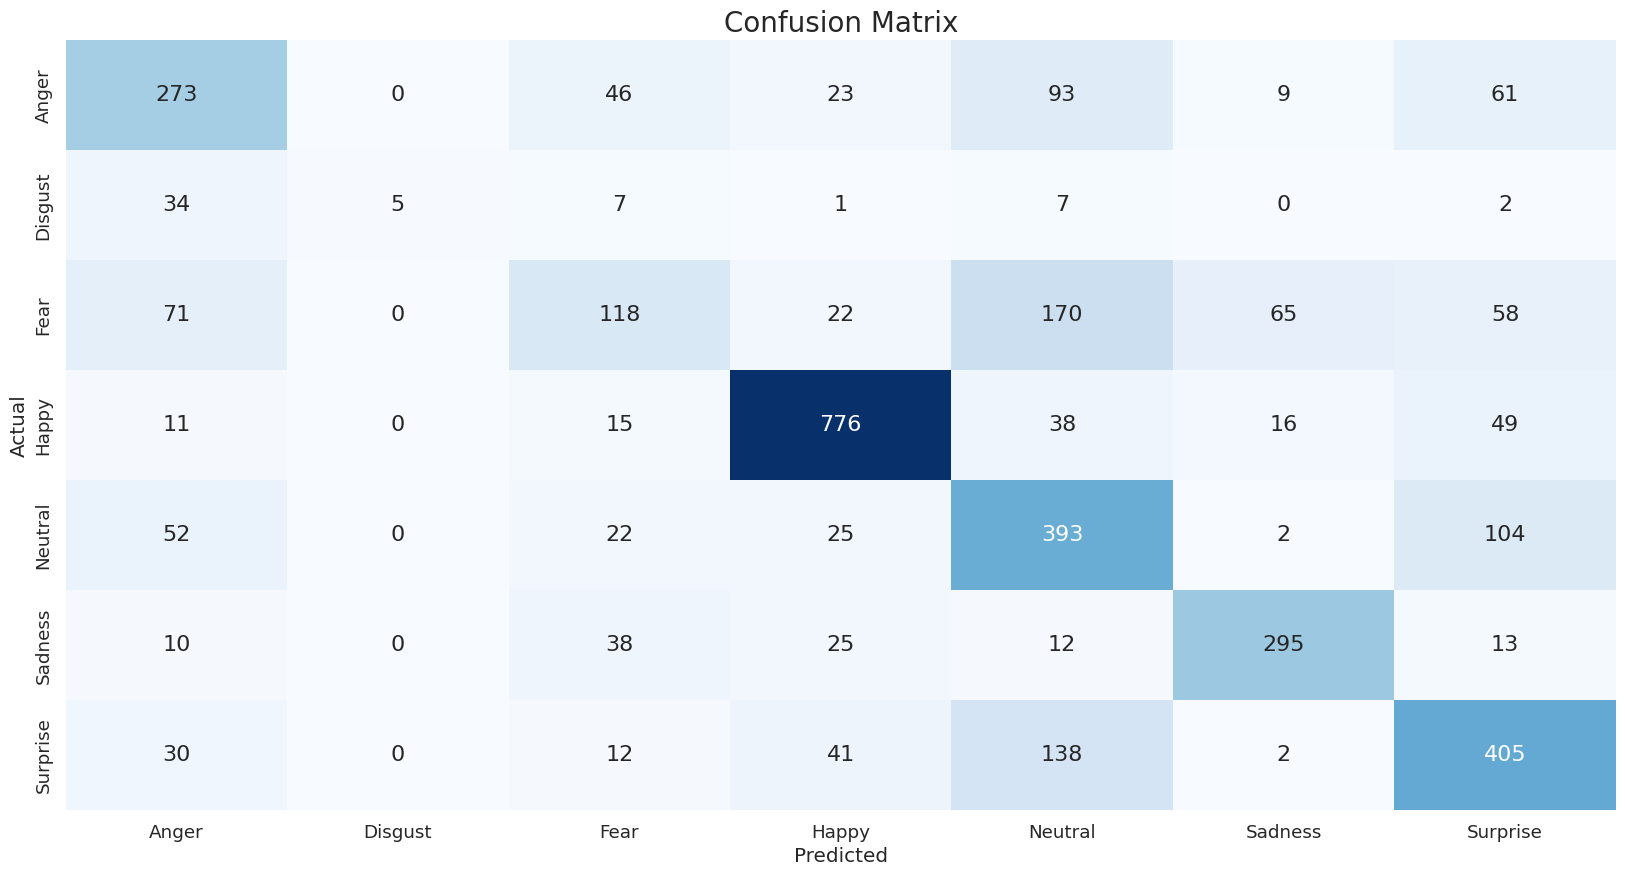

In [ ]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [ ]:
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.568     0.541     0.554       505
           1      1.000     0.089     0.164        56
           2      0.457     0.234     0.310       504
           3      0.850     0.857     0.854       905
           4      0.462     0.657     0.542       598
           5      0.758     0.751     0.754       393
           6      0.585     0.645     0.614       628

    accuracy                          0.631      3589
   macro avg      0.669     0.539     0.542      3589
weighted avg      0.636     0.631     0.620      3589



# **6. Demostration**

*The demo of predicting the facial expression of detected faces by Haar-Cascade face detection algorithm by using our trained model:*

---



# ***Testing***

*table of the dataset*

---



In [ ]:
emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts().sort_index().reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Disgust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


*bar chart of each emotion class*

---



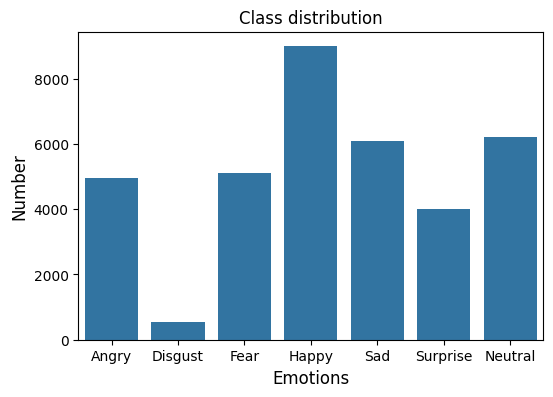

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(x=emotion_counts.emotion, y=emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

*Sample image*

---



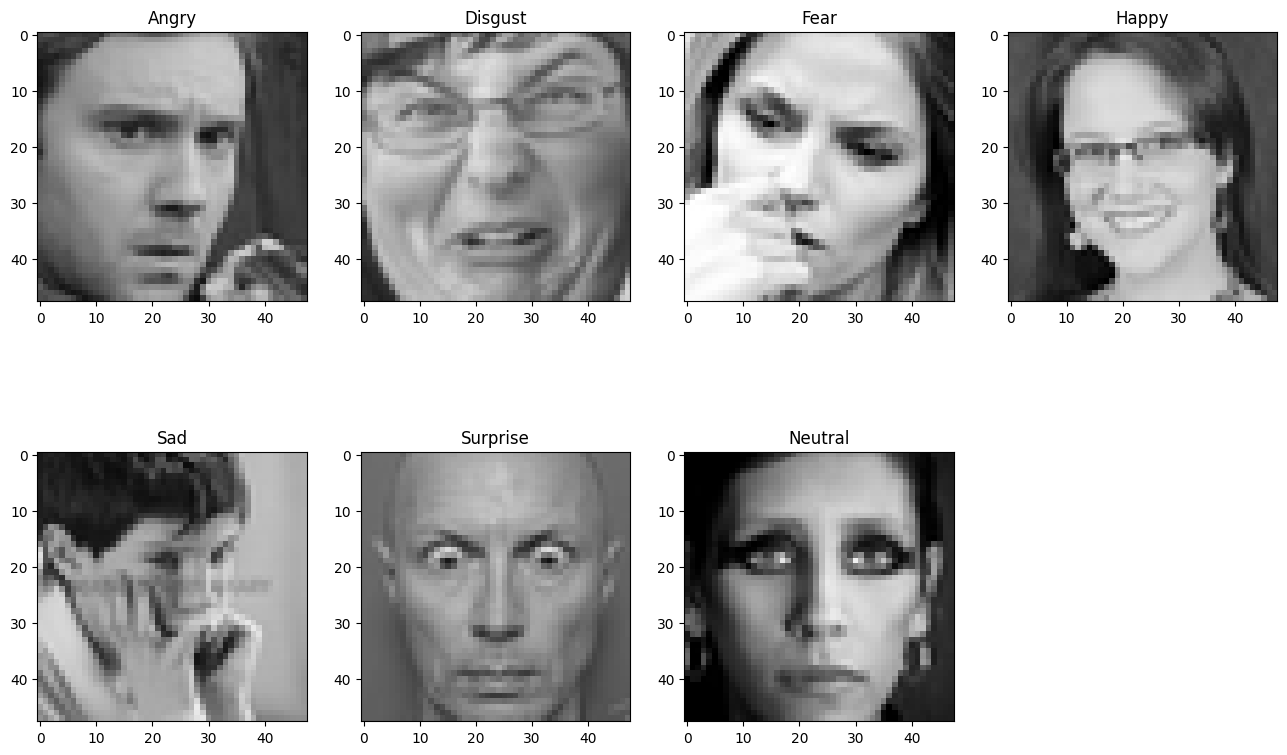

In [ ]:
def row2image_label(row):
  pixels, emotion = row['pixels'], emotion_map[row['emotion']]
  img = np.array(pixels.split())
  img = img.reshape(48, 48)
  image = np.zeros((48, 48, 3))
  image[:, :, 0] = img
  image[:, :, 1] = img
  image[:, :, 2] = img
  return image.astype(np.uint8), emotion

plt.figure(0, figsize=(16, 10))
for i in range (1, 8):
  face = data[data['emotion'] == i-1].iloc[0]
  img, label = row2image_label(face)
  plt.subplot(2, 4, i)
  plt.imshow(img)
  plt.title(label)

plt.show()